=== Prime–Golden–Sphere (One-Cell) ===
phi = 1.618033988749895
P_MAX = 2,000,000 | primes count = 148,933 | sieve time = 0.12s
S_P(phi) = sum_{p <= P} p^(-phi) = 0.716853161381
4π S_P(phi) = 9.008242501993  | nearest integer = 9 | |·-9| = 8.242502e-03

[Gauss-flux]         4π Σ p^{-phi} =  9.008242501993
[Spherical integral] 4π Σ p^{-phi} =  9.008242501993 (theory, exact)
[Spherical integral] Monte-Carlo ≈    9.041653033487 (MC samples=200,000, trunc @ 50,000)
[Shell area-mass]    4π Σ p^{-phi} =  9.008242501993 (beta=1, alpha=2+phi=3.618033988750)

Checkpoints (cutoff, #primes, S_partial, 4πS_partial, nearest_int):
  P<=     100:  #     25  S=0.701204927  4πS=8.811601  ⟂9
  P<=    1000:  #    168  S=0.714158141  4πS=8.974376  ⟂9
  P<=   10000:  #   1229  S=0.716355397  4πS=9.001987  ⟂9
  P<=  100000:  #   9592  S=0.716764809  4πS=9.007132  ⟂9
  P<= 1000000:  #  78498  S=0.716845349  4πS=9.008144  ⟂9
  P<= 2000000:  # 148933  S=0.716853161  4πS=9.008243  ⟂9


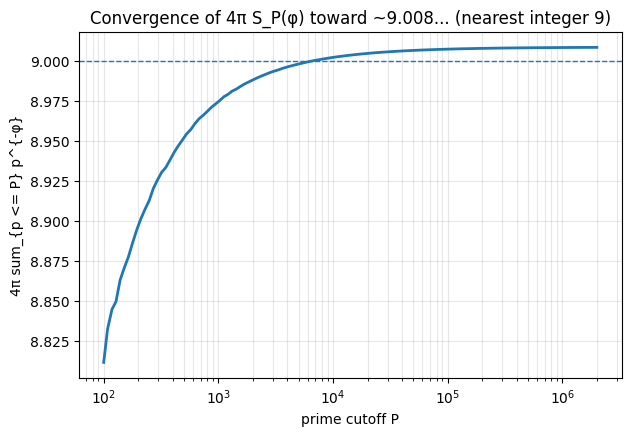


Timing: sieve 0.12s | sums 0.08s | geom 35.42s | total 35.62s


In [3]:
# === Prime–Golden–Sphere: one-cell Colab test (self-contained) ===
# Goals:
#  (A) Compute S_P(phi) = sum_{p <= P_max} p^{-phi} and 4*pi*S_P(phi)
#  (B) Show the same value emerges from:
#      (B1) Gauss-flux normalization (charges q_p = p^{-phi})
#      (B2) Spherical mean / l=0 pickoff via a zonal Poisson kernel mixture
#      (B3) Geometry-of-numbers shell model with r_p = p^1, w(r) = r^{-(2+phi)}
#  (C) Optional Monte-Carlo integral on S^2 to verify (B2) numerically
#  (D) Convergence plot and nearest-integer check

import math, sys, time, random
import numpy as np
import mpmath as mp
import matplotlib.pyplot as plt

# -----------------------------
# Config (edit these freely)
# -----------------------------
P_MAX = 2000000         # prime cutoff (largest prime included). 2e6 ≈ fast on Colab (~few seconds)
DO_MONTE_CARLO = True   # set False to skip the S^2 Monte Carlo check for speed
MC_SAMPLES = 200000      # number of uniform samples on S^2 if DO_MONTE_CARLO=True
SHOW_CONVERGENCE = True  # show plot of 4π S_P(phi) vs P
PRINT_SAMPLE_CHECKPOINTS = [10**2, 10**3, 10**4, 10**5, 10**6, 2*10**6]

# Golden ratio
phi = (1 + 5**0.5) / 2

# -----------------------------
# Utilities
# -----------------------------
def sieve_primes(n):
    """Return list of all primes <= n using a fast sieve."""
    if n < 2:
        return []
    size = n + 1
    sieve = bytearray(b'\x01') * size
    sieve[0:2] = b'\x00\x00'
    m = int(n**0.5)
    for p in range(2, m+1):
        if sieve[p]:
            step = p
            start = p*p
            sieve[start:size:step] = b'\x00' * ((n - start)//step + 1)
    return [i for i in range(size) if sieve[i]]

def spherical_uniform(n):
    """Sample n points uniformly on S^2; return array shape (n,3)."""
    u = np.random.rand(n)
    v = np.random.rand(n)
    theta = 2*np.pi * u
    z = 2*v - 1
    r_xy = np.sqrt(np.maximum(0.0, 1 - z*z))
    x = r_xy * np.cos(theta)
    y = r_xy * np.sin(theta)
    return np.column_stack([x,y,z])

def poisson_kernel_on_s2(cos_theta, rho):
    """
    3D Poisson kernel (harmonic measure density on S^2 from interior point of radius rho along +z).
    Integral over S^2 equals 4*pi, independent of rho.
    Formula: K_rho(θ) = (1 - rho^2) / (1 - 2*rho*cosθ + rho^2)^(3/2)
    """
    num = 1 - rho*rho
    den = (1 - 2*rho*cos_theta + rho*rho)**1.5
    return num / den

# -----------------------------
# Step 1: primes and S_P(phi)
# -----------------------------
t0 = time.time()
primes = sieve_primes(P_MAX)
t1 = time.time()

weights = np.array([p**(-phi) for p in primes], dtype=np.float64)
S_phi = float(np.sum(weights))
four_pi_S_phi = 4*np.pi*S_phi

# Convergence checkpoints
check_log = []
for cutoff in PRINT_SAMPLE_CHECKPOINTS:
    if cutoff <= P_MAX:
        # sum over primes <= cutoff
        idx = np.searchsorted(primes, cutoff, side='right')
        S_partial = float(np.sum(weights[:idx]))
        val = 4*np.pi*S_partial
        check_log.append((cutoff, idx, S_partial, val, round(val)))
t2 = time.time()

# -----------------------------
# Step 2: Three geometric routes
# -----------------------------
# (B1) Gauss-flux normalization: flux = 4*pi * sum q_p, with q_p = p^{-phi}
flux_gauss = 4*np.pi * S_phi

# (B2) Spherical mean / l=0 pickoff via a Poisson-kernel mixture:
# Build a zonal kernel K(θ) = sum_p w_p * K_rho_p(θ), with w_p = p^{-phi}, rho_p ∈ (0,1).
# The spherical integral is 4π * sum_p w_p because ∫ K_rho dΩ = 4π for each rho.
# We'll choose rho_p = 1 - 1/(1 + p^{1/3}) (monotone in p, bounded away from 1)
def rho_of_p(p):
    return 1.0 - 1.0/(1.0 + p**(1/3))

# Analytic total spherical integral (exact) for the mixture:
spherical_integral_theory = 4*np.pi * S_phi

# Optional Monte Carlo check: approximate ∫_{S^2} K dΩ
mc_estimate = None
if DO_MONTE_CARLO:
    dirs = spherical_uniform(MC_SAMPLES)  # unit vectors on S^2
    # polar angle cosθ relative to +z: it's just z coordinate
    cos_theta = dirs[:,2]
    # Evaluate K at each sample by summing contributions of each p (too slow if we do ALL primes).
    # So we use a truncated mixture (small primes dominate because of p^{-phi}).
    # Keep the first M terms so that residual is tiny.
    # Heuristic: include primes <= 50k (tunable). You can increase if you want.
    P_TRUNC = min(P_MAX, 50000)
    idx_trunc = np.searchsorted(primes, P_TRUNC, side='right')
    ps_trunc = np.array(primes[:idx_trunc])
    ws_trunc = np.array([p**(-phi) for p in ps_trunc], dtype=np.float64)
    rhos = np.array([rho_of_p(int(p)) for p in ps_trunc], dtype=np.float64)
    # Evaluate K mixture at sampled angles
    # K(θ) = sum_i w_i * K_rho_i(θ)
    # Vectorize: for each rho_i, compute K_rho_i(cosθ) and accumulate with weight
    K_vals = np.zeros(MC_SAMPLES, dtype=np.float64)
    for w, rho in zip(ws_trunc, rhos):
        K_vals += w * poisson_kernel_on_s2(cos_theta, rho)
    # Monte Carlo integral on S^2 ~ (4π) * average(K)
    mc_estimate = 4*np.pi * float(np.mean(K_vals))
    # Add back the omitted tail analytically: (sum_{p > P_TRUNC} w_p) * ∫K_rho dΩ = 4π * tail
    tail = float(np.sum(weights[idx_trunc:]))
    mc_estimate += 4*np.pi * tail

# (B3) Geometry-of-numbers shell model:
# Choose beta = 1, alpha = 2 + phi so that area*weight = 4π * p^{2 - alpha} = 4π * p^{-phi}.
alpha = 2.0 + phi
beta = 1.0
# r_p = p^beta, surface area = 4π r_p^2 = 4π p^{2β}, density w(r) = r^{-alpha} = p^{-alphaβ}
# Contribution per prime: 4π * p^{2β - alphaβ} = 4π * p^{-phi}
shell_total = 4*np.pi * S_phi

t3 = time.time()

# -----------------------------
# Step 3: Nearest-integer / convergence plot
# -----------------------------
nearest_int = int(round(four_pi_S_phi))
err_to_9 = abs(four_pi_S_phi - 9.0)

# -----------------------------
# Reporting
# -----------------------------
print("=== Prime–Golden–Sphere (One-Cell) ===")
print(f"phi = {(phi):.15f}")
print(f"P_MAX = {P_MAX:,} | primes count = {len(primes):,} | sieve time = {t1-t0:.2f}s")
print(f"S_P(phi) = sum_{'{p <= P}'} p^(-phi) = {S_phi:.12f}")
print(f"4π S_P(phi) = {four_pi_S_phi:.12f}  | nearest integer = {nearest_int} | |·-9| = {err_to_9:.6e}")
print()
print("[Gauss-flux]         4π Σ p^{-phi} = ", f"{flux_gauss:.12f}")
print("[Spherical integral] 4π Σ p^{-phi} = ", f"{spherical_integral_theory:.12f}", "(theory, exact)")
if mc_estimate is not None:
    print("[Spherical integral] Monte-Carlo ≈   ", f"{mc_estimate:.12f}",
          f"(MC samples={MC_SAMPLES:,}, trunc @ {int(P_TRUNC):,})")
print("[Shell area-mass]    4π Σ p^{-phi} = ", f"{shell_total:.12f}",
      f"(beta=1, alpha=2+phi={alpha:.12f})")
print()
print("Checkpoints (cutoff, #primes, S_partial, 4πS_partial, nearest_int):")
for c in check_log:
    cutoff, idx, Spart, val, nint = c
    print(f"  P<={cutoff:>8}:  #{idx:>7}  S={Spart:.9f}  4πS={val:.6f}  ⟂{nint}")

if SHOW_CONVERGENCE:
    # Build a light convergence curve using geometric spaced cutoffs
    grid = np.unique(np.logspace(2, math.log10(P_MAX), 120, base=10).astype(int))
    vals = []
    i = 0
    cumsum = 0.0
    # Precompute cumulative partial sums for speed
    w = weights
    for p in primes:
        cumsum += p**(-phi)
        vals.append(cumsum)
    vals = np.array(vals)
    y = []
    x = []
    for cut in grid:
        idx = np.searchsorted(primes, cut, side='right')
        x.append(cut)
        y.append(4*np.pi*vals[idx-1] if idx>0 else 0.0)
    plt.figure(figsize=(7,4.5))
    plt.plot(x, y, linewidth=2)
    plt.axhline(9.0, linestyle="--", linewidth=1)
    plt.xlabel("prime cutoff P")
    plt.ylabel("4π sum_{p <= P} p^{-φ}")
    plt.title("Convergence of 4π S_P(φ) toward ~9.008... (nearest integer 9)")
    plt.xscale('log')
    plt.grid(True, which='both', alpha=0.3)
    plt.show()

print(f"\nTiming: sieve {t1-t0:.2f}s | sums {t2-t1:.2f}s | geom {t3-t2:.2f}s | total {t3-t0:.2f}s")